<a href="https://colab.research.google.com/github/Ry02024/SIGNATE/blob/main/%E3%82%A2%E3%83%A4%E3%83%A1%E3%81%AE%E5%88%86%E9%A1%9E/%E3%82%A2%E3%83%A4%E3%83%A1%E3%81%AE%E5%88%86%E9%A1%9E(%E5%88%86%E6%9E%90%E3%83%BB%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.データの読み込み

In [3]:
base_dir = "/content/drive/MyDrive/SIGNATE/アヤメの分類/data/"

In [13]:
ls {base_dir}

sample_submit.csv  test.tsv  train.tsv


In [4]:
import pandas as pd

# 学習用データと評価用データを読み込む
train_data = pd.read_csv(base_dir + 'train.tsv', delimiter='\t')
test_data = pd.read_csv(base_dir + 'test.tsv', delimiter='\t')


# 2.データの前処理

In [6]:
# 不要な列（id）を削除
train_data.drop(columns='id', inplace=True)
test_data.drop(columns='id', inplace=True)

# データ型の確認と変換 (ここでは変換の必要がないと仮定)
print(train_data.dtypes)


sepal length in cm    float64
sepal width in cm     float64
petal length in cm    float64
petal width in cm     float64
class                  object
dtype: object


# 3.探索的データ分析

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm
count,75.000000,75.000000,75.000000,75.000000
mean,5.922667,3.097333,3.844000,1.220000
std,0.877277,0.443565,1.852116,0.787572
min,4.400000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.550000,0.200000
50%,5.900000,3.000000,4.400000,1.400000
75%,6.450000,3.350000,5.250000,1.800000
max,7.900000,4.200000,6.900000,2.500000


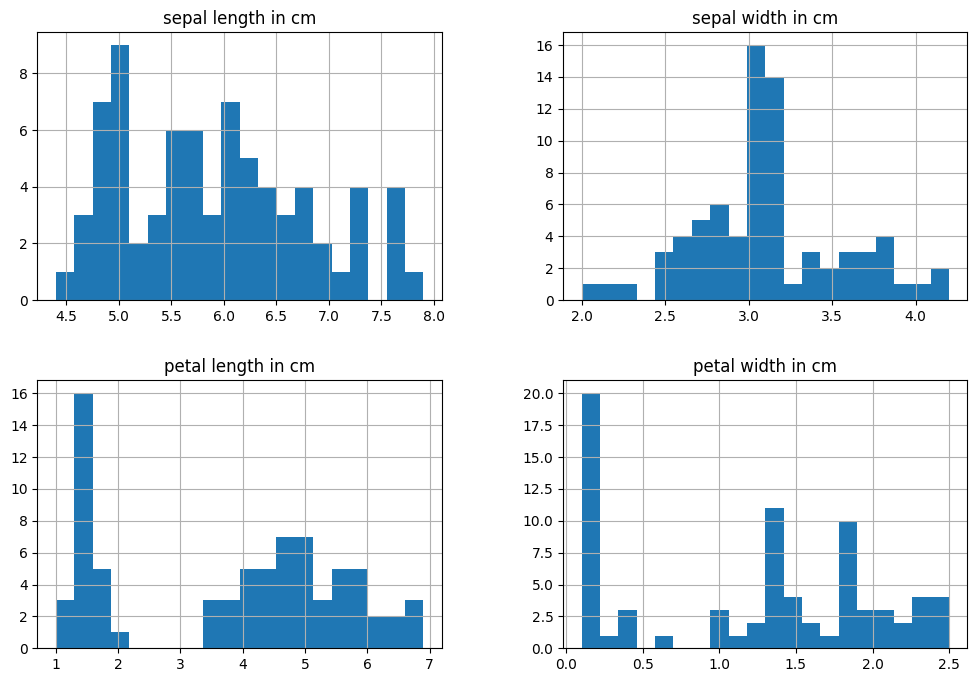

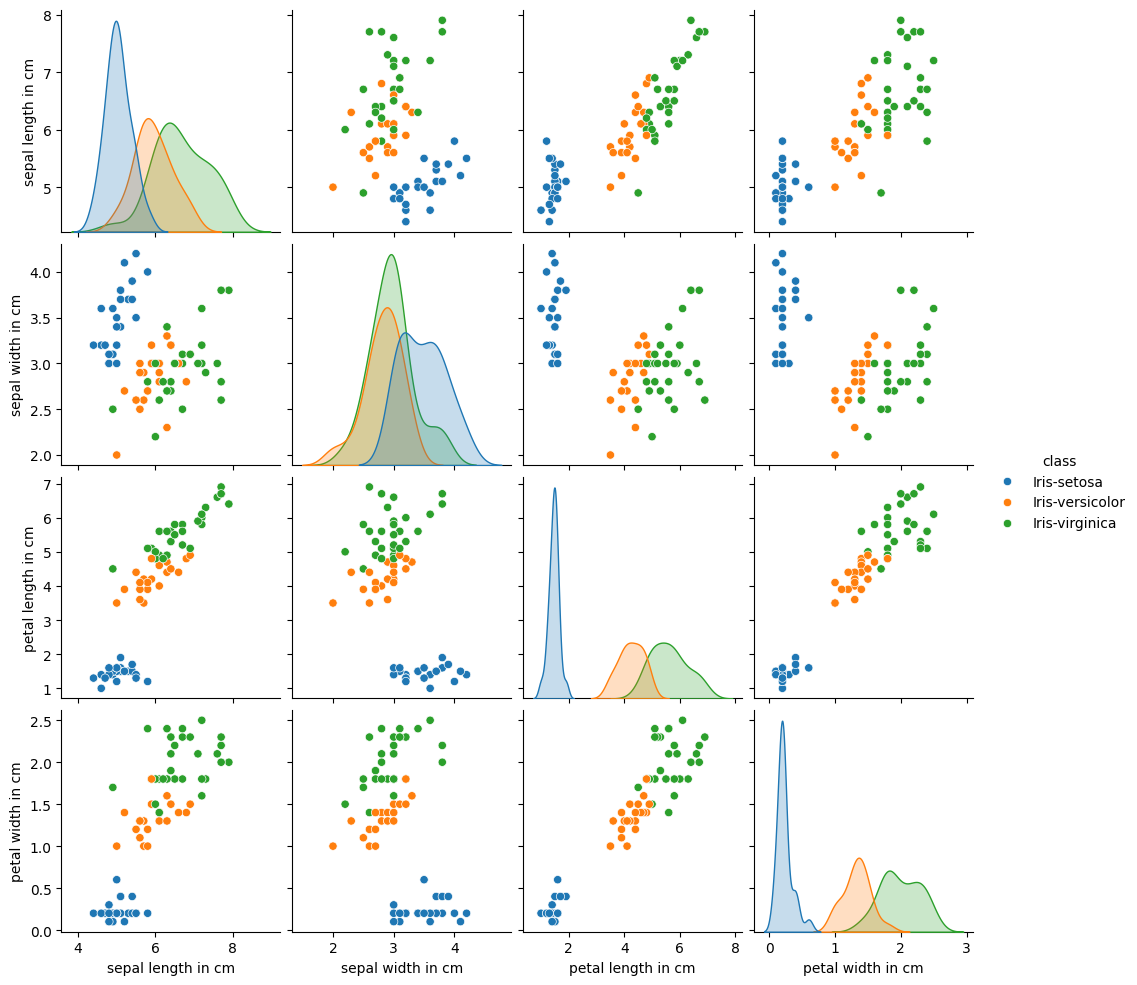

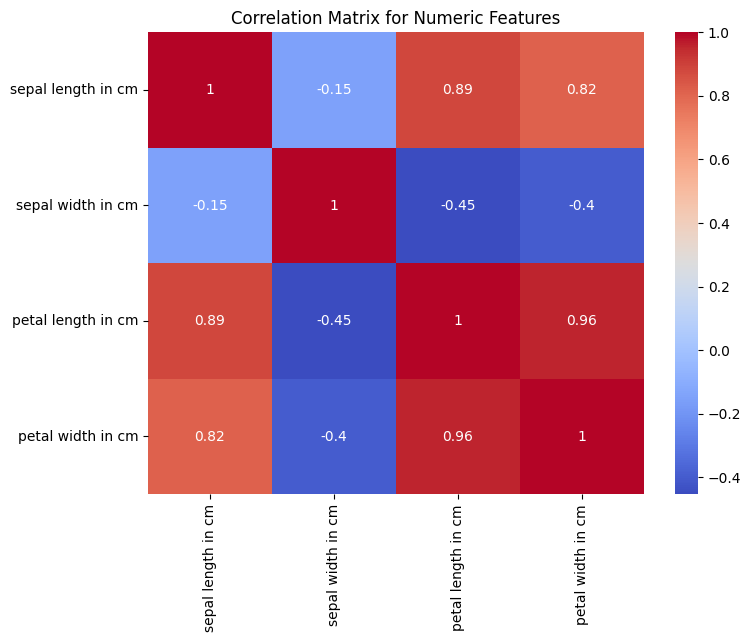

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 各品種の統計量を確認
display(train_data.describe())

# 各特徴量の分布をヒストグラムで確認
train_data.hist(bins=20, figsize=(12, 8))
plt.show()

# 特徴量間の相関を散布図行列で確認
sns.pairplot(train_data, hue='class')
plt.show()

# 'class'列を除外して数値データのみのデータフレームを作成
numeric_data = train_data.select_dtypes(include=[np.number])

# 数値データのみを含むデータフレームで相関係数を計算し、ヒートマップで表示
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()


## 3-1.分析から分かった事

提供された画像から分析結果を見て、アヤメデータに関していくつかの興味深い観察ができます：

1. **基本統計と分布**:
   - 全ての特徴量（がく片の長さ、幅、花弁の長さ、幅）はサンプルサイズが75であり、欠損値がないことが確認できます。
   - 平均、中央値、四分位数を見ると、データのスケールが異なるため、特徴量の正規化や標準化が有効である可能性が示唆されます。

2. **ヒストグラム**:
   - 特徴量のヒストグラムは、特に花弁の長さと幅に関しては、明確なグルーピング（ビン）が見られます。これは、特定の品種が特定の範囲に集中していることを示しており、品種識別に役立ちます。
   - がく片の幅は特に集中した分布を示しており、この特徴が最も品種分類に寄与するかもしれません。

3. **散布図とカーネル密度推定**:
   - 散布図行列とカーネル密度推定は、特徴量間の関係と品種によるグループ化を明確に示しています。
   - 特に花弁の長さと幅は非常に高い正の相関を示しており、これらの特徴量が互いに強く関連していることを示唆しています。これは、分類モデルの特徴選択に影響を与えるかもしれません。

4. **相関行列**:
   - 花弁の長さと幅の相関係数は0.96と非常に高く、これらの特徴が似た情報を持っている可能性があります。これにより、多重共線性の問題が発生する可能性があるため、モデル構築時には注意が必要です。
   - がく片の長さも花弁の長さと幅と高い正の相関を示しています。

これらの観察から、特に花弁の長さと幅はアヤメの品種分類に非常に重要な特徴であることがわかります。分類モデルを構築する際には、これらの特徴を重視すると良いでしょう。また、散布図からは品種によってクラスターが形成されているのが見て取れるため、これを利用して効果的な特徴量を選定することができます。

# 4. モデルの構築

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 特徴量とターゲットに分割
X = train_data.drop('class', axis=1)
y = train_data['class']

# データの分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 特徴量のスケーリング
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# モデルの構築とハイパーパラメータのチューニング
model = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_


# 5.モデルの評価

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix

# バリデーションデータでの性能評価
y_pred = best_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Accuracy: 1.0
Confusion Matrix:
 [[6 0 0]
 [0 3 0]
 [0 0 6]]


# 6.評価用データでの予測

In [14]:
ls {base_dir}

sample_submit.csv  test.tsv  train.tsv


In [16]:
# 評価用データの特徴量をスケーリング
X_test = scaler.transform(test_data.drop('class', axis=1, errors='ignore'))

# 評価用データで予測
predictions = best_model.predict(X_test)

# サンプル提出ファイルを読み込む
sample_submission = pd.read_csv(base_dir + 'sample_submit.csv', header=None)  # ヘッダーがない場合はNoneを指定

# 予測結果をサンプル提出ファイルに格納
sample_submission[1] = predictions  # 2列目に予測結果を格納

# 提出ファイルをCSV形式で保存
sample_submission.to_csv('submission.csv', index=False, header=False)

# 7.機械学習を通して分かった事

提供されたコードとプロセスから得られる主な洞察と考慮すべき点は以下の通りです：

### 1. モデルの構築とハイパーパラメータの最適化
- **ランダムフォレスト**を使用してモデルを構築しました。ランダムフォレストは、多くの決定木を組み合わせたアンサンブル学習モデルで、高い予測性能と良好な汎化能力を持っています。
- **グリッドサーチ**を利用してモデルのハイパーパラメータをチューニングしました。これにより、`n_estimators`（決定木の数）と`max_depth`（木の深さ）の最適な組み合わせを自動的に見つけ出すことができます。これは過学習や未学習を避けるのに役立ちます。

### 2. モデルの評価
- **精度（Accuracy）**と**混同行列（Confusion Matrix）**を用いて、バリデーションデータセットに対するモデルの性能を評価しました。精度はモデルが正確に分類したサンプルの割合を示し、混同行列は各クラスにおける正確な予測と誤った予測の詳細を提供します。

### 3. 評価用データでの予測と提出ファイルの準備
- モデルを使用して**評価用データセット**に対する予測を行いました。これは、実際の運用環境や競技会でのパフォーマンスを模倣する良い方法です。
- 予測結果を**サンプル提出ファイル**に格納し、フォーマットに従ってCSVファイルとして保存しました。これにより、モデルの結果を簡単に提出できるようになります。

### 考慮すべき点
- **特徴量のスケーリング**が正しく行われているか確認することが重要です。特に、訓練データで学習したスケーラーを使用して評価データを変換している点が適切です。
- **評価用データセット**の`'class'`列を削除する処理で、`errors='ignore'`オプションを使用している点は注意が必要です。これは該当列が存在しない場合でもエラーを発生させずに処理を続行するためです。
- 精度だけでなく、他の指標（例えば、**F1スコア**や**AUC-ROCカーブ**）も考慮に入れると、モデルの評価がより全面的に行えます。

これらのポイントを踏まえ、モデルの改善やさらなる調整を検討することができます。モデルが実際にどれだけの性能を発揮しているかを理解するためには、これらの評価指標が非常に重要です。